In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The following python code will use the OS library to use Operating System libraries, giving you access to the file system, and the zipfile library allowing you to unzip the data. 

In [4]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/dataset/training.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
local_zip = '/content/drive/MyDrive/dataset/test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/training`, which in turn each contain `hi` and `background` subdirectories.

In short: The training set is the data that is used to tell the neural network model that 'this is what a hi looks like', 'this is what a background looks like' etc. 

One thing to pay attention to in this sample: We do not explicitly label the images as hi's or background's.

Later you'll see something called an *ImageGenerator* being used -- and this is coded to read images from subdirectories, and automatically label them from the name of that subdirectory. So, for example, you will have a 'training' directory containing a 'his' directory and a 'backgrounds' one. ImageGenerator will label the images appropriately for you, reducing a coding step. 

Let's define each of these directories:

In [5]:
# Directory with our training hi pictures
train_hi_dir = os.path.join('/tmp/training/hi')

# Directory with our training background pictures
train_background_dir = os.path.join('/tmp/training/background')


Now, let's see what the filenames look like in the `his` and `backgrounds` training directories:

In [6]:
train_hi_names = os.listdir(train_hi_dir)
print(train_hi_names[:10])
train_background_names = os.listdir(train_background_dir)
print(train_background_names[:10])

['fabric_3_c2_39_none_none.jpg', 'door_6_c4_80_none_edgeEnhance.jpg', 'fabric_19_c1_95_rotate_sharpen.jpg', 'tent_9_c8_51_none_none.jpg', 'door_24_c1_55_rotate_blur.jpg', 'wall_16_c10_44_none_blur.jpg', 'fabric_25_c1_4_flip_smooth.jpg', 'door_30_c7_46_none_sharpen.jpg', 'fabric_19_c1_95_rotate_none.jpg', 'door_38_c4_39_rotate_none.jpg']
['displayPanel_4_none_smooth_d3.jpg', 'door_30_flip_sharpen.jpg', 'fabric_23_flip_sharpen_d2.jpg', 'wall_15_none_sharpen_d3.jpg', 'door_13_none_none_d2.jpg', 'wall_5_rotate_smooth_d2.jpg', 'envelope_16_rotate_blur.jpg', 'fabric_25_rotate_none.jpg', 'door_29_rotate_edgeEnhance.jpg', 'dressingCase_4_rotate_none_d2.jpg']


Let's find out the total number of hi and background images in the directories:

In [7]:
print('total training hi images:', len(os.listdir(train_hi_dir)))
print('total training background images:', len(os.listdir(train_background_dir)))

total training hi images: 1425
total training background images: 4450


Now let's take a look at a few pictures to get a better sense of what they look like. First, configure the matplot parameters:

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 hi and 8 background pictures. You can rerun the cell to see a fresh batch each time:

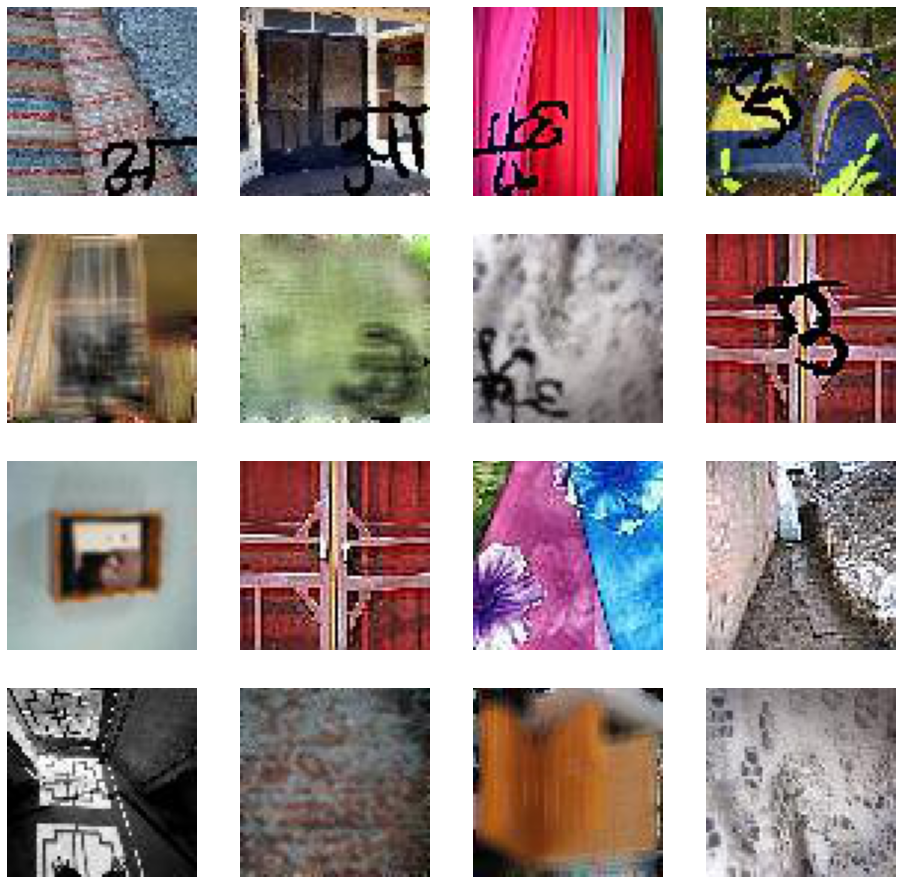

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_hi_pix = [os.path.join(train_hi_dir, fname) 
                for fname in train_hi_names[pic_index-8:pic_index]]
next_background_pix = [os.path.join(train_background_dir, fname) 
                for fname in train_background_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_hi_pix+next_background_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building a Small Model from Scratch

But before we continue, let's start defining the model:

Step 1 will be to import tensorflow.

In [10]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [11]:
import tensorflow as tf
print(tf.__version__)

2.6.0


We then add convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers.

Finally we add the densely connected layers. 

Note that because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


The model.summary() method call prints a summary of the NN 

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 78400)             0

In [14]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/training/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 5875 images belonging to 2 classes.


### Training
Let's train for 15 epochs -- this may take a few minutes to run.

Do note the values per epoch.

The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses. 

In [16]:
history = model.fit(
      train_generator,  
      epochs=15,
      steps_per_epoch=8,
      validation_steps=8,
      verbose=1)

Epoch 1/15
8/8 [==============================] - 94s 11s/step - loss: 11.3213 - accuracy: 0.5518
Epoch 2/15
8/8 [==============================] - 87s 11s/step - loss: 0.6816 - accuracy: 0.6543
Epoch 3/15
8/8 [==============================] - 86s 11s/step - loss: 0.5307 - accuracy: 0.7842
Epoch 4/15
8/8 [==============================] - 87s 11s/step - loss: 0.5223 - accuracy: 0.7881
Epoch 5/15
8/8 [==============================] - 88s 11s/step - loss: 0.4989 - accuracy: 0.7910
Epoch 6/15
8/8 [==============================] - 88s 11s/step - loss: 0.3905 - accuracy: 0.8525
Epoch 7/15
8/8 [==============================] - 93s 12s/step - loss: 0.3986 - accuracy: 0.8369
Epoch 8/15
8/8 [==============================] - 89s 11s/step - loss: 0.3214 - accuracy: 0.8867
Epoch 9/15
8/8 [==============================] - 89s 11s/step - loss: 0.3514 - accuracy: 0.8838
Epoch 10/15
8/8 [==============================] - 89s 11s/step - loss: 0.3518 - accuracy: 0.8682
Epoch 11/15
8/8 [===========

In [23]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
l=[]
for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = x / 255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    #print(fn + " is a hindi alphabet")
    l.append(1)
  else:
    # print(fn + " is not a hindi alphabet")
    l.append(0)
print(l)

Saving 1.jpg to 1 (3).jpg
Saving 2.jpg to 2 (1).jpg
Saving 3.jpg to 3.jpg
Saving 4.jpg to 4.jpg
Saving 5.jpg to 5.jpg
Saving 6.jpg to 6.jpg
Saving 7.jpg to 7.jpg
Saving 8.jpg to 8.jpg
Saving 9.jpg to 9.jpg
Saving 10.jpg to 10.jpg
Saving 11.jpg to 11.jpg
Saving 12.jpg to 12.jpg
Saving 13.jpg to 13.jpg
Saving 14.jpg to 14.jpg
Saving 15.jpg to 15.jpg
Saving 16.jpg to 16.jpg
Saving 17.jpg to 17.jpg
Saving 18.jpg to 18 (1).jpg
Saving 19.jpg to 19.jpg
Saving 20.jpg to 20.jpg
Saving 21.jpg to 21.jpg
Saving 22.jpg to 22.jpg
Saving 23.jpg to 23.jpg
Saving 24.jpg to 24.jpg
Saving 25.jpg to 25.jpg
Saving 26.jpg to 26.jpg
Saving 27.jpg to 27.jpg
Saving 28.jpg to 28.jpg
Saving 29.jpg to 29.jpg
Saving 30.jpg to 30.jpg
Saving 31.jpg to 31.jpg
Saving 32.jpg to 32.jpg
Saving 33.jpg to 33.jpg
Saving 34.jpg to 34.jpg
Saving 35.jpg to 35.jpg
Saving 36.jpg to 36.jpg
Saving 37.jpg to 37.jpg
Saving 38.jpg to 38.jpg
Saving 39.jpg to 39.jpg
Saving 40.jpg to 40.jpg
Saving 41.jpg to 41.jpg
Saving 42.jpg to 42.jp

In [28]:
d={"1.png": 3, "2.png": 3, "3.png": 3, "4.png": 3, "5.png": 3, "6.png": 3, "7.png": 3, "8.png": 3, "9.png": 3, "10.png": 3, "11.png": 3, "12.png": 3, "13.png": 3, "14.png": 3, "15.png": 3, "16.png": 3, "17.png": 3, "18.png": 3, "19.png": 3, "20.png": 3, "21.png": 3, "22.png": 3, "23.png": 3, "24.png": 3, "25.png": 3, "26.png": 3, "27.png": 3, "28.png": 3, "29.png": 3, "30.png": 3, "31.png": 3, "32.png": 3, "33.png": 3, "34.png": 3, "35.png": 3, "36.png": 3, "37.png": 3, "38.png": 3, "39.png": 3, "40.png": 3, "41.png": 3, "42.png": 3, "43.png": 3, "44.png": 3, "45.png": 3, "46.png": 3, "47.png": 3, "48.png": 3, "49.png": 3, "50.png": 3, "51.png": 3, "52.png": 3, "53.png": 3, "54.png": 3, "55.png": 3, "56.png": 3, "57.png": 3, "58.png": 3, "59.png": 3, "60.png": 3, "61.png": 3, "62.png": 3, "63.png": 3, "64.png": 3, "65.png": 3, "66.png": 3, "67.png": 3, "68.png": 3, "69.png": 3, "70.png": 3, "71.png": 3, "72.png": 3, "73.png": 3, "74.png": 3, "75.png": 3, "76.png": 3, "77.png": 3, "78.png": 3, "79.png": 3, "80.png": 3, "81.png": 3, "82.png": 3, "83.png": 3, "84.png": 3, "85.png": 3, "86.png": 3, "87.png": 3, "88.png": 3, "89.png": 3, "90.png": 3, "91.png": 3, "92.png": 3, "93.png": 3, "94.png": 3, "95.png": 3, "96.png": 3, "97.png": 3, "98.png": 3}
for i in range(1,99):
  d[str(i)+".png"]=l[i-1]
print(d)

{'1.png': 1, '2.png': 0, '3.png': 1, '4.png': 0, '5.png': 1, '6.png': 0, '7.png': 1, '8.png': 0, '9.png': 0, '10.png': 0, '11.png': 1, '12.png': 0, '13.png': 1, '14.png': 1, '15.png': 1, '16.png': 0, '17.png': 0, '18.png': 0, '19.png': 1, '20.png': 1, '21.png': 1, '22.png': 1, '23.png': 1, '24.png': 1, '25.png': 1, '26.png': 1, '27.png': 0, '28.png': 1, '29.png': 1, '30.png': 1, '31.png': 0, '32.png': 0, '33.png': 0, '34.png': 1, '35.png': 0, '36.png': 0, '37.png': 0, '38.png': 0, '39.png': 0, '40.png': 1, '41.png': 0, '42.png': 1, '43.png': 0, '44.png': 1, '45.png': 0, '46.png': 1, '47.png': 0, '48.png': 1, '49.png': 0, '50.png': 1, '51.png': 1, '52.png': 1, '53.png': 1, '54.png': 1, '55.png': 0, '56.png': 0, '57.png': 0, '58.png': 0, '59.png': 0, '60.png': 0, '61.png': 1, '62.png': 1, '63.png': 1, '64.png': 0, '65.png': 0, '66.png': 0, '67.png': 1, '68.png': 0, '69.png': 1, '70.png': 1, '71.png': 0, '72.png': 0, '73.png': 1, '74.png': 0, '75.png': 0, '76.png': 0, '77.png': 0, '78.png

In [29]:
import json 
# Serializing json  
json_object = json.dumps(d, indent = 4) 
print(json_object)

{
    "1.png": 1,
    "2.png": 0,
    "3.png": 1,
    "4.png": 0,
    "5.png": 1,
    "6.png": 0,
    "7.png": 1,
    "8.png": 0,
    "9.png": 0,
    "10.png": 0,
    "11.png": 1,
    "12.png": 0,
    "13.png": 1,
    "14.png": 1,
    "15.png": 1,
    "16.png": 0,
    "17.png": 0,
    "18.png": 0,
    "19.png": 1,
    "20.png": 1,
    "21.png": 1,
    "22.png": 1,
    "23.png": 1,
    "24.png": 1,
    "25.png": 1,
    "26.png": 1,
    "27.png": 0,
    "28.png": 1,
    "29.png": 1,
    "30.png": 1,
    "31.png": 0,
    "32.png": 0,
    "33.png": 0,
    "34.png": 1,
    "35.png": 0,
    "36.png": 0,
    "37.png": 0,
    "38.png": 0,
    "39.png": 0,
    "40.png": 1,
    "41.png": 0,
    "42.png": 1,
    "43.png": 0,
    "44.png": 1,
    "45.png": 0,
    "46.png": 1,
    "47.png": 0,
    "48.png": 1,
    "49.png": 0,
    "50.png": 1,
    "51.png": 1,
    "52.png": 1,
    "53.png": 1,
    "54.png": 1,
    "55.png": 0,
    "56.png": 0,
    "57.png": 0,
    "58.png": 0,
    "59.png": 0,
    

In [27]:
import pandas as pd
df=pd.DataFrame(l)
df.to_csv("/content/drive/MyDrive/hindisolution.csv")


In [31]:
out_file = open("/content/drive/MyDrive/myfile.json", "w") 
    
json.dump(d, out_file, indent = 6) 
    
out_file.close() 